In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from utils import sample_PLN
import scipy.linalg as SLA
import torch.linalg as TLA
import scipy
from fastPLN import fastPLN
from scipy.special import factorial
import math
import seaborn as sns 
import torch 
from pandas import read_csv

device :  cpu


In [2]:
%load_ext autoreload

%autoreload 2

$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=\mathbf{x}_{i}\beta +W_{i}\mathbf{C}^{\top}, \quad i \in 1, \ldots, n \\
Y_{i j} \mid Z_{i j} & \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
\end{aligned}
$$

We want to maximize the log likelihood with respect to $\theta$ : 


$$\max _{\theta} P_{\theta}(Y)$$

But we need to integrate out $W$ in order to compute the quantity inside the max : 

$$
\begin{aligned}
P_{\theta}\left(Y_{i}\right) &=\int P_{\theta}\left(Y_{i}, W\right) d W \\
&=\int P_{\theta}\left(Y_{i} \mid W\right) p(W) d W
\end{aligned}
$$

This integral being untractable, we are going to approximate it with Monte Carlo methods : 

$$
\int p_{\theta}\left(Y_{i} \mid W\right) p(W) d W \approx \frac{1}{K} \sum_{k = 1 }^Kp_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)
$$
$$W_{i,k} \sim \mathcal N (0, I_q)$$

The larger the $K$ the better the approximation.  

Let's compute $p_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)$. 


First, 

$$
P\left(W_{i,k}\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2}\left\|W_{i,k}\right\|_{2}^{2}\right)
$$ 

Then, 

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i,k}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i,k}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{j}+W_{i,k}^{\top} C^{\top} _{j}
$$

For numerical purposes, we may want to use a logarithmic scale and apply the exponential function after. Indeed, $Y_{ij}$ can go up to a thousand, and computing this factorial would give infinite values. 

$$
\log p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=\sum_{j=1}^{p} - \ln \left(Y_{i j} !\right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+Z_{i j}\right)
$$

If we consider the whole likelihood : 

$$
\begin{aligned}
\ln p_{\theta}\left(Y \mid W_{k}\right) &=\sum_{i=1}^{n} \log p_{\theta}\left(Y_{i} \mid W_{i k}\right) \\
&=\sum_{i=1}^{n} \sum_{j} - \ln \left(Y_{ij} ! \right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right) \\
&=1_{n}^{T}\left[-\ln (Y !)-\exp (0+Z)+Y \odot (0+Z)\right] 1_{p} \\
Z=& X \beta+W_{k} C^{\top}
\end{aligned}
$$

We are going tu use the Stirling Formula in order to compute the log of the factorial, to avoid computing directly the factorial.  

We now need to compute the gradients. Since 

$$
\nabla_{\theta} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i}| W_{i,k}\right) \nabla_{\theta} \log p_{\theta}\left(Y_{i} \mid W_{i,k}\right)
$$

We get : 

$$
\nabla_{\beta} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i} \mid W_{i,k}\right)\left[-x_{i}^{\top} \exp \left(0_{i}+x_{i}^{\top} \beta+W_{i,k}^{\top} C^{\top}\right)+ x_{i}^{\top}Y_i\right]
$$
$$
\nabla_{C} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i} \mid W_{i,k}\right)\left[-W_{i,k}^{\top} \exp \left(0_{i}+x_{i}^{\top} \beta+W_{i,k}^{\top} C^{\top}\right)+ W_{i,k}^{\top}Y_i\right]
$$
This is if we take only one sample $Y_i$. If we take the whole dataset (or a mini-batch), we get (writed in matrix form) :

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$C :  (p,q)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

In [238]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    np.random.seed(0)
    alea = np.random.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = np.zeros((p,p))
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*0.95**np.arange(block_size)
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*toeplitz(0.98**np.arange(last_block_size))
    return Sigma+0.1*toeplitz(0.95**np.arange(p))


def C_from_Sigma(Sigma,q): 
    w,v = SLA.eigh(Sigma)
    C_reduct = v[:,-q:]@np.diag(np.sqrt(w[-q:]))
    return C_reduct

In [239]:
d = 4 # nb of cavariates
n = 200;  p = 10
q = 3

In [240]:
#torch.manual_seed(0)
true_Sigma = torch.from_numpy(build_block_Sigma(p,3))
true_C = torch.from_numpy(C_from_Sigma(true_Sigma, q))
true_beta =torch.randn((d, p))

covariates = torch.randn((n,d))/10
O =  1+torch.zeros((n,p))
sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma,true_beta, O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)

In [241]:
print(Y_sampled)

tensor([[  8,   2,   5,  ...,   8,  12,   0],
        [  9,   6,   4,  ...,   5,   7,   3],
        [ 12,  14,  16,  ...,   0,   0,   0],
        ...,
        [  1,   3,   7,  ...,  16,  14,   0],
        [  0,   1,   0,  ..., 116, 100,  15],
        [  1,   4,   3,  ...,   2,   1,   1]])


In [84]:
print(covariates@true_beta)

tensor([[-0.6770, -1.8332,  0.8517, -0.3622],
        [-0.0147, -1.4039,  0.7270, -1.6743],
        [-0.7963, -2.1970, -0.3506,  0.2023],
        [ 1.9993, -0.2395, -0.4235, -1.3158],
        [-0.6169,  1.0364,  1.2339,  0.3564],
        [ 3.3514,  0.0191,  0.7540, -2.0378],
        [-2.1235,  0.5776,  1.9738,  0.1352],
        [-2.0279,  2.5704,  0.3475,  3.2637],
        [-3.4273,  1.2245, -0.5945,  3.6548],
        [-4.1411, -1.4654,  0.7253,  3.3505],
        [-0.1886,  6.7877,  0.8461,  3.8859],
        [-1.1607, -0.9435, -0.8499,  1.6444],
        [ 1.2559,  1.2483,  0.3944, -0.8037],
        [ 1.9975, -0.0336,  0.0459, -0.3742],
        [-0.3025,  1.4703, -0.7248,  1.9832],
        [-1.0773,  2.1747,  0.4766,  1.7719],
        [ 0.2120,  2.6086, -0.5086,  0.7988],
        [ 3.7268, -5.8038, -0.3481, -5.7029],
        [-2.7119,  1.0946,  1.3409,  2.0723],
        [-2.1023, -0.3917, -0.4127,  0.0301],
        [-0.4296,  0.3289,  0.7286, -1.0426],
        [-3.2960,  6.5339, -2.3002

<AxesSubplot:>

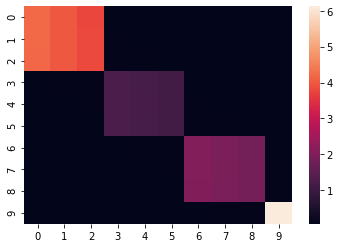

In [242]:
sns.heatmap(true_Sigma)

In [70]:
def log_stirling(n_):
    '''
    this function computes log(n!) even for n large. We use the Stirling formula to avoid 
    numerical infinite values of n!. It can also take tensors.
    
    args : 
         n_ : tensor. 
    return : an approximation of log(n!)
    '''
    n = torch.clone(n_) #clone the tensor by precaution
    n+= (n==0) # replace the 0 with 1. It changes anything since 0! = 1! 
    return torch.log(torch.sqrt(2*np.pi*n))+n*torch.log(n/math.exp(1)) #Stirling formula

In [247]:
class MC_PLNPCA(): 
    
    def __init__(self,q, batch_size): 
        self.q = q
        self.batch_size = batch_size 
        pass
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        torch.manual_seed(0)
        self.Y = Y 
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        self.C = torch.clone(true_C)
        self.C.requires_grad_(True)
        self.beta = torch.randn(self.d,self.p)
        self.beta = torch.clone(true_beta)
        self.beta.requires_grad_(True)
        
    def single_likelihood_test(self,i,acc): 
        '''
        computes the likelihood of a single point. Useless since We can compute it efficiently
        with batch_likelihood(). This is more a beta version. 
        '''
        N_iter = int(1/acc)
        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:]
        O_i = self.O[i,:]
        E = 0
        for _ in range(N_iter):
            W = torch.randn(self.q)
            log_fact = torch.sum(log_stirling(Y_i))
            norm_W = 1/2*torch.norm(W)**2
            poiss_like = - torch.sum(torch.exp(self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)) 
            poiss_like += torch.sum((self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)*self.Y[i,:])
            E+= torch.exp(-log_fact -norm_W + poiss_like)
        return E/N_iter 
    def get_Sigma(self):
        '''
        simple function to get Sigma
        '''
        return self.C@(self.C.T)

    def get_batch(self,batch_size): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always an integer)
                    
        '''
        np.random.seed(0)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        self.batch_size = batch_size 
        nb_full_batch, last_batch_size  = self.n//self.batch_size, self.n % self.batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    self.covariates[indices[i*self.batch_size: (i+1)*self.batch_size]],
                    self.O[indices[i*self.batch_size: (i+1)*self.batch_size]]) 
                        
                  
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]])
        
    def compute_likelihood(self, acc): 
        '''
        computes the likelihood of the whole dataset. 
        '''
        likelihood = 0
        N_samples = int(1/acc)
        for Y_b, covariates_b, O_b in self.get_batch(self.batch_size): 
            W = torch.randn(N_samples, self.batch_size, self.q)
            likelihood +=  self.batch_likelihood(Y_b,covariates_b,O_b,W)
        return likelihood
            
    def fit(self, N_iter, acc,lr_beta,lr_C,C_optim = False): 
        '''
        fit the data. DOes not work yet. You can choose to optimize beta or C
        '''
        optim_beta = torch.optim.SGD([self.beta], lr = lr_beta)
        optim_C = torch.optim.Rprop([self.C], lr = lr_C)
        N_samples = int(1/acc)
        for i in range(N_iter):
            for Y_b, covariates_b, O_b in self.get_batch(self.batch_size):
                W = torch.randn(N_samples,self.batch_size, self.q) 
                if C_optim : 
                    optim_C.zero_grad()
                    print('MSE Sigma: ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    grad_C = self.grad_batch_C(Y_b, covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    diff= torch.norm(grad_C+self.C.grad)/(torch.norm(grad_C)+torch.norm(self.C.grad))
                    if diff <0  : 
                        print('mine', grad_C)
                        print('true : ', self.C.grad)
                    #self.C.grad =  -grad_C/torch.norm(grad_C)
                    print('loss : ', loss.item())
                    optim_C.step()
                else : 
                    optim_beta.zero_grad()
                    
                    grad_beta = self.grad_batch_beta(Y_b,covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    self.beta.grad = -grad_beta/torch.mean(torch.abs(grad_beta))
                    if loss <0 : 
                        print('MSE beta_before : ', torch.mean((self.beta-true_beta)**2).item())
                        optim_beta.step()
                        print('MSE beta_after : ', torch.mean((self.beta-true_beta)**2).item())
                    #print('beta : ',self.beta )
            print('----------------------------------------------------------------------new_epoch')
            print('likelihood : ', self.compute_likelihood(acc))

    
    def batch_likelihood(self, Y_b,covariates_b, O_b, W, mean = True): 
        norm_W = torch.sum(torch.norm(W,dim = 2)**2, axis = 1) 
        log_fact = torch.sum(log_stirling(Y_b))
        Z_b = covariates_b@self.beta + W@(self.C.T)
        exp_term = -torch.sum(torch.exp(O_b+Z_b),axis = (1,2))
        data_term = torch.sum(Y_b * (O_b + Z_b),axis = (1,2))
        
        '''
        result = (-1/2*norm_W -log_fact +exp_term+data_term) 
        print('Z_b +O_b : ', torch.sum(covariates_b@self.beta + W@(self.C.T)+O_b ,axis = (1,2)))
        print('norm_W div  : ', -1/2*norm_W/result )
        print('norm_W : ', -1/2*norm_W )
        print('log_fact div : ', -log_fact/result)
        print('log_fact', -log_fact)
        print('expdiv : ', exp_term/result)
        print('exo ', exp_term)
        print('datadiv', data_term/result )
        print('data',data_term)
        print('res : ', result )
        print('expres ! ', torch.exp(result))
        '''
        if mean : 
            return torch.mean(torch.exp(-1/2*norm_W -log_fact +exp_term+data_term))
        else : 
            return torch.exp(-1/2*norm_W -log_fact +exp_term+data_term)
    def grad_batch_beta(self, Y_b,covariates_b, O_b, W):
        likelihood =  self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return torch.mean(likelihood.reshape(-1,1,1)*(covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b)), axis = 0) 
        
    def grad_batch_C(self, Y_b,covariates_b, O_b, W): 
        likelihood =  self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return torch.mean(likelihood.reshape(-1,1,1)*((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W), axis = 0) 
        
    def fit_batch(self, Y_b,covariates_b, O_b, W): 
        optim = torch.optim.Rprop([self.beta, self.C], lr = 0.01)
        optim.zero_grad()
        loss = self.batch_likelihood(Y_b, covariates_b, O_b, W)
        loss.backward()
        print('loss : ', loss )
        grad_C = self.grad_batch_C(Y_b, covariates_b, O_b, W)
        true_grad = self.C.grad
        diff = torch.norm(grad_C-true_grad)
        print('diff : ', diff)
        print('my_grad : ', grad_C)
        print('true : ', true_grad)
        
    def fit_all(self,lr_beta,lr_C, N_iter,acc): 
        optim_beta = torch.optim.Rprop([self.beta], lr = lr_beta)
        optim_C = torch.optim.Rprop([self.C], lr = lr_C)
        for i in range(N_iter):
            optim_beta.zero_grad()
            optim_C.zero_grad()
            loss = -self.compute_likelihood(acc)
            loss.backward()
            #print('grad : ', self.beta.grad)
            optim_beta.step()
            optim_C.step()
            
            print('---------------------MSE Sigma: ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
            print('MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
            print('likelihood--------------------------------------',self.compute_likelihood(acc))

In [248]:
batch_size = 1
model = MC_PLNPCA(q,batch_size)
model.init_data(Y_sampled, O, covariates)
model.fit_all(0.1,0.1,N_iter = 50, acc = 0.001)
#model.compute_likelihood(0.0001)
#model.fit(10,0.001, lr_beta = 0.1,lr_C = 0.1, C_optim = False)

---------------------MSE Sigma:  0.22480206825156315
MSE beta :  0.010000000000000004
likelihood-------------------------------------- tensor(3.2483e-05, grad_fn=<AddBackward0>)
---------------------MSE Sigma:  0.6235860799384809
MSE beta :  0.041680000000000016
likelihood-------------------------------------- tensor(8.9407e-05, grad_fn=<AddBackward0>)
---------------------MSE Sigma:  1.6706252907037646
MSE beta :  0.09502990000000003
likelihood-------------------------------------- tensor(0.0003, grad_fn=<AddBackward0>)
---------------------MSE Sigma:  3.9533002743698087
MSE beta :  0.177551932
likelihood-------------------------------------- tensor(0.0006, grad_fn=<AddBackward0>)
---------------------MSE Sigma:  8.95800835427072
MSE beta :  0.29906296816
likelihood-------------------------------------- tensor(0.0013, grad_fn=<AddBackward0>)
---------------------MSE Sigma:  19.84899836040876
MSE beta :  0.47901448990719986
likelihood-------------------------------------- tensor(0.0029

---------------------MSE Sigma:  9743.91295210357
MSE beta :  38811.480036268666
likelihood-------------------------------------- tensor(0.0749, grad_fn=<AddBackward0>)


In [234]:
model.beta

tensor([[ 53.1172,  54.9169,  57.1006,   5.8670,   9.7988,  55.8536, -19.7243,
          54.5041,  55.5516,  73.7415],
        [ -1.6841,  -1.8241,  -3.9329,  -1.9162,   2.1200,  -0.3344, -38.8216,
          -2.2547,  -4.1625,  -0.9848],
        [-24.1910, -23.9034,  -8.3193,   0.3848,   1.0350, -13.9846,   1.3624,
         -34.1909, -23.0386,   0.5268],
        [  9.6812,   9.9008,  13.0152,   1.7178,   1.3332,   8.4896,  -0.6718,
           5.2278,   6.7412,  -0.1647]], requires_grad=True)

In [235]:
true_beta

tensor([[-1.8136, -0.6513,  1.8937,  0.7632, -0.1027,  0.5357,  1.4522,  0.1101,
          0.5326, -0.2131],
        [-0.7202, -0.1027,  0.8985, -0.6883, -0.3802,  0.5361, -0.4484,  0.6421,
         -1.4641, -1.2042],
        [ 0.9864, -1.0280, -0.8013,  1.0045,  1.1537,  0.4313,  0.7548, -1.4239,
          0.6443,  0.9832],
        [-0.2799,  0.0106, -0.1753,  0.7863,  1.3945,  1.1535, -2.0487,  0.8947,
         -0.6329, -0.2511]])

In [222]:
model.compute_likelihood(0.00001)

tensor(1.8855e-10, grad_fn=<AddBackward0>)

<AxesSubplot:>

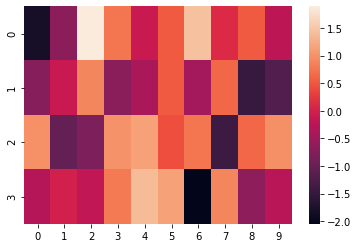

In [226]:
sns.heatmap(true_beta)

In [81]:
batch_size = n//5
model = MC_PLNPCA(q,batch_size)
model.init_data(Y_sampled, O, covariates)

for Y_b, covariates_b, O_b in model.get_batch(model.batch_size): 
    W = torch.randn(5, model.batch_size,q)
    model.fit_batch(Y_b, covariates_b, O_b,W)
    

Z_b +O_b :  tensor([26.4781, 15.2091, 18.0693, 22.1403, 15.8713], grad_fn=<SumBackward1>)
norm_W div  :  tensor([4.0302e-05, 3.8500e-05, 2.6256e-05, 3.1458e-05, 1.7748e-05],
       grad_fn=<DivBackward0>)
norm_W :  tensor([-10.0561,  -9.8419,  -6.5526,  -7.9348,  -4.4420])
log_fact div :  tensor([1.1244, 1.0975, 1.1242, 1.1123, 1.1210], grad_fn=<DivBackward0>)
log_fact tensor(-280567.7702)
expdiv :  tensor([0.0059, 0.0051, 0.0071, 0.0043, 0.0079], grad_fn=<DivBackward0>)
exo  tensor([-1469.6753, -1303.5968, -1776.8250, -1087.4623, -1977.7734],
       grad_fn=<NegBackward>)
datadiv tensor([-0.1304, -0.1027, -0.1314, -0.1167, -0.1289], grad_fn=<DivBackward0>)
data tensor([32529.0306, 26245.2563, 32788.5509, 29429.4423, 32266.7483],
       grad_fn=<SumBackward1>)
res :  tensor([-249518.4710, -255635.9526, -249562.5969, -252233.7249, -250283.2373],
       grad_fn=<AddBackward0>)
expres !  tensor([0., 0., 0., 0., 0.], grad_fn=<ExpBackward>)
loss :  tensor(0., grad_fn=<MeanBackward0>)
Z_b +O

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i,k}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i,k}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{j}+W_{i,k}^{\top} C^{\top} _{j}
$$




<AxesSubplot:>

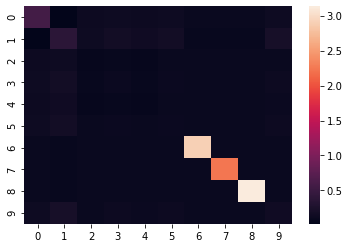

In [113]:
sns.heatmap(model.get_Sigma().detach().numpy())

<AxesSubplot:>

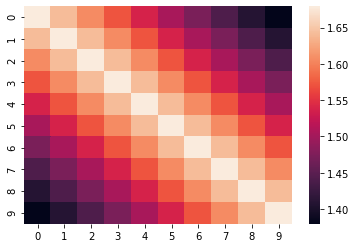

In [275]:
sns.heatmap(true_Sigma)

In [ ]:
 '''   def compute_single_log_like(self, i, acc):
        N_iter = int(1/acc)
        E = 0 
        for _ in range(N_iter): 
            W = np.random.randn(q)
            E -= 1/2*SLA.norm(W)**2
            E -= np.sum(np.exp(self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)) 
            E+= np.sum((self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)*self.Y[i,:])
            #print('E : ', E)
        E/= N_iter
        return E
    
    def batch_log_like(self,acc): 
        batch_E = 0
        for i in range(10): 
            batch_E += self.compute_single_log_like(i,acc) 
        return batch_E
    
    def single_grad_beta_log_like(self,i, acc): 
        N_iter = int(1/acc)
        grad = 0
        for _ in range(N_iter): 
            W = np.random.randn(q)
            grad += self.covariates[i,:].T.reshape(-1,1)@(np.exp(self.O[i,:]+ self.covariates[i,:]@self.beta+self.C@W)).reshape(1,-1)
            grad += self.covariates[i,:].T.reshape(-1,1)@(self.Y[i,:].reshape(1,-1))
        return grad/N_iter
'''
'''
fonctions pour tester les gradients avec des W que l'on simule qu'une seule fois 
    def batch_grad_beta(self, acc): 
        batch_grad = 0
        for i in range(10): 
            batch_grad += self.single_grad_beta_log_like(i,acc) 
        return batch_grad
        
        def single_likelihood(self,i,W): 
            ## W should be an array of size q 
            

        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:]
        O_i = self.O[i,:]

        norm_W = TLA.norm(W)**2
        log_fact = -torch.sum(log_stirling(Y_i))
        Z_i = x_i@self.beta + W@(self.C.T)
        exp_term = -torch.sum(torch.exp(O_i +Z_i))
        data_term = torch.sum(Y_i*(O_i+Z_i))
        return torch.exp(log_fact + exp_term + data_term-1/2*norm_W)
            
    def single_grad_beta(self,i,W): 
        likeli = self.single_likelihood(i,W)
        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:].reshape(1,-1)
        O_i = self.O[i,:]
        exp = torch.exp(O_i + x_i@self.beta + W@(self.C.T))
        return likeli*(x_i.T@(-exp+Y_i))
    
    def single_fit(self,i,W): 
        loss = self.single_likelihood(i,W)
        loss.backward()
        print('error : ', torch.norm(self.beta.grad-self.single_grad_beta(i,W)))
    def batch_likelihood_test(self,Y_b,covariates_b, O_b, W): 
        norm_W = torch.sum(torch.norm(W, dim = 1)**2)
        log_fact = torch.sum(log_stirling(Y_b))
        Z_b = covariates_b@self.beta + W@(self.C.T)
        exp_term = -torch.sum(torch.exp(O_b+Z_b))
        data_term = torch.sum(Y_b * (O_b + Z_b))
        return torch.exp(-log_fact-norm_W/2 +exp_term + data_term)
    
    def batch_grad_beta_test(self,Y_b,covariates_b, O_b, W): 
        likelihood =  self.batch_likelihood_test(Y_b,covariates_b, O_b, W)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return likelihood*(covariates_b.T@(-torch.exp(Z_b)+Y_b))
        
   '''
        

In [27]:
class MC_PLNPCA_bis(): 
    
    def __init__(self,q, batch_size): 
        self.q = q
        self.batch_size = batch_size 
        pass
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        
        self.Y = Y 
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        #self.C = torch.clone(true_C)
        self.C.requires_grad_(True)
        self.beta = torch.randn(self.d,self.p)
        #self.beta = torch.clone(true_beta)
        self.beta.requires_grad_(True)
        
        
    
    def single_likelihood_test(self,i,acc): 
        '''
        computes the likelihood of a single point. Useless since We can compute it efficiently
        with batch_likelihood(). This is more a beta version. 
        '''
        N_iter = int(1/acc)
        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:]
        O_i = self.O[i,:]
        E = 0
        for _ in range(N_iter):
            W = torch.randn(self.q)
            log_fact = torch.sum(log_stirling(Y_i))
            norm_W = 1/2*torch.norm(W)**2
            poiss_like = - torch.sum(torch.exp(self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)) 
            poiss_like += torch.sum((self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)*self.Y[i,:])
            E+= torch.exp(-log_fact -norm_W + poiss_like)
        return E/N_iter 
    def get_Sigma(self):
        '''
        simple function to get Sigma
        '''
        return self.C@(self.C.T)
    



    def get_batch(self,batch_size): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always an integer)
                    
        '''
        np.random.seed(0)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        self.batch_size = batch_size 
        nb_full_batch, last_batch_size  = self.n//self.batch_size, self.n % self.batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    self.covariates[indices[i*self.batch_size: (i+1)*self.batch_size]],
                    self.O[indices[i*self.batch_size: (i+1)*self.batch_size]]) 
                        
                  
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]])
        
    def compute_likelihood(self, acc): 
        likelihood = 0
        N_samples = int(1/acc)
        W = torch.randn(N_samples, self.n, self.q)
        likelihood +=  self.batch_likelihood(self.Y,self.covariates, self.O,W)
        return likelihood/self.n
    
    
    
    
    def batch_grad_beta(self,Y_b,covariates_b, O_b,W): 
        grad = 0
        log_like = torch.sum(self.batch_likelihood(Y_b,covariates_b, O_b,W, somme = False), axis = 1)
        first_term = -torch.exp(O_b +covariates_b@self.beta + W@(self.C.T))
        second_term = Y_b
        grad =  torch.sum(torch.multiply(log_like.reshape(-1,1,1),((covariates_b.T)@(first_term + second_term))), axis = 0)
        # the for loop here does the same, just a sanity check
        '''
        grad = 0
        for k in range(N_samples): 
            log_like = self.batch_likelihood(Y_b,covariates_b, O_b,W[k])#/N_samples
            exp_term  = -torch.exp(O_b +covariates_b@self.beta + W[k]@(self.C.T))
            grad +=  log_like*(covariates_b.T)@(exp_term + Y_b)
        '''
        return grad/W.shape[0]
    
    
    def batch_grad_C(self,Y_b,covariates_b, O_b,W): 
        grad = 0 
        for k in range(W.shape[0]):
            log_like = self.batch_likelihood(Y_b,covariates_b, O_b,W[k], somme = True)
            exp_term  = -torch.exp(O_b +covariates_b@self.beta + W[k]@(self.C.T))
            grad +=  log_like*((exp_term + 0*Y_b).T@W[k])
        return grad/W.shape[0]
            
    def fit(self, N_iter, acc): 
        optim_beta = torch.optim.Rprop([self.beta], lr = 0.3)
        optim_C = torch.optim.Rprop([self.C], lr = 0.3)
        N_samples = int(1/acc)
        for i in range(N_iter):
            for Y_b, covariates_b, O_b in self.get_batch(self.batch_size):
                W = torch.randn(N_samples,self.batch_size, self.q) 
                if False : 
                    optim_C.zero_grad()
                    #print('MSE Sigma: ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    grad_C = self.batch_grad_C(Y_b, covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    #self.C.grad =  -grad_C/torch.norm(grad_C)
                    print('loss : ', loss.item())
                    optim_C.step()
                else : 
                    optim_beta.zero_grad()
                    print('MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
                    grad_beta = self.batch_grad_beta(Y_b,covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    self.beta.grad = -grad_beta/torch.mean(torch.abs(grad_beta))
                    optim_beta.step()
            print('----------------------------------------------------------------------new_epoch')
            
            
    def batch_likelihood(self,Y_batch,covariates_batch, O_batch, W, somme = True ): 
        '''
        computes the approximation of the likelihood of a batch. 
        
        args : 
                'Y_batch' : tensor of size(batch_size, p)
                'covariates_batch' : tensor of size(batch_size, d)
                'O_batch' : tensor of size(batch_size, p)
                'acc' : float. the accuracy you want. The lower the accuracy, the lower the algorithm. 
                        we will sampThe size of tensor a (1000) must match the size of tensor b (20) at non-singleton dimension 2les 1/acc times. 
        returns : 
                the approximation of the likelihood. 
        ''' 
    
        last_dim = len(W.shape)-1
        if last_dim >1 : 
            N_samples = W.shape[0] # number of samples of W 
        else : N_samples = 1
        #N_samples = W.shape[0]
        Z = covariates_batch@self.beta + W@(self.C.T)
        norm_W = TLA.norm(W, dim = last_dim)**2
        log_fact =  torch.sum(log_stirling(Y_batch), axis = 1) # the factorial term 
        poiss_like =  - torch.sum(torch.exp(O_batch+Z), axis = last_dim) # first term of the poisson likelihood
                                                                         #the normalising term with the exponential 
        poiss_like += torch.sum((O_batch+Z)*Y_batch, axis = last_dim)    # second term of the poisson likelihood
        
            
        if somme : 
            # If we want the true likelihood
            # We first take the exponential of the sum of the logs and then divide by the Number of samples we took.  
            return torch.sum(torch.exp(-log_fact -1/2*norm_W+poiss_like))/N_samples 
        #for some purposes, we may want only the exponential and not the sum
        else : return torch.exp(-log_fact -1/2*norm_W+poiss_like)/N_samples

In [28]:
model_bis = MC_PLNPCA_bis(q,n//2) 
model_bis.init_data(Y_sampled, O,covariates )
model_bis.fit(20,0.01)

MSE beta :  1.9102846328682492
MSE beta :  1.8096150648046705
----------------------------------------------------------------------new_epoch
MSE beta :  1.8552132061091728
MSE beta :  1.9129760878867497
----------------------------------------------------------------------new_epoch
MSE beta :  2.0701245395137264
MSE beta :  2.3871577710512315
----------------------------------------------------------------------new_epoch
MSE beta :  2.6920821053624366
MSE beta :  3.339558541508027
----------------------------------------------------------------------new_epoch
MSE beta :  4.266740013933548
MSE beta :  5.829849607680941
----------------------------------------------------------------------new_epoch
MSE beta :  8.225635687097924
MSE beta :  9.993858093434689
----------------------------------------------------------------------new_epoch
MSE beta :  13.342151645474365
MSE beta :  14.396301048193923
----------------------------------------------------------------------new_epoch
MSE beta : 